#**Import Libraries**



In [1]:
# Import necessary standard libraries for operating system interactions, numerical computations, data manipulation, and data visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import TensorFlow and Keras modules for building deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Import TensorFlow Keras callbacks for saving the best model and early stopping during training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Import library for image processing
from PIL import Image

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow and Keras modules for image data augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import library to handle file operations in Google Colab
from google.colab import files

#**Download Dataset**

In [2]:
# Upload the kaggle.json file to Colab to authenticate the Kaggle API
files.upload()

# Create the Kaggle directory and move kaggle.json to it
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

# Unzip the dataset into the specified directory, remove duplicates if any
!unzip -o 140k-real-and-fake-faces.zip -d /content

# Clean up by removing the downloaded zip file to save space
!rm 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: /content/real

#**Data Processing**

In [3]:
# The mean and std values that were calculated previously for the training data
mean = [0.52074927, 0.42581322, 0.38057297]  # Mean for each channel (R, G, B)
std  = [0.27928742, 0.25401181, 0.2549746 ]  # Standard deviation for each channel (R, G, B)

# Normalize the image data: scale pixel values between [0, 1], then apply mean and std normalization
def preprocess_input(image):
    return (image / 255.0 - mean) / std  # Scale to [0, 1], then normalize

# Create ImageDataGenerators using the preprocessing function
train = ImageDataGenerator(preprocessing_function=preprocess_input)
valid = ImageDataGenerator(preprocessing_function=preprocess_input)
test  = ImageDataGenerator(preprocessing_function=preprocess_input)

#**Creating Datasets**

In [4]:
# Create the datasets with normalization applied

# Training dataset
train_dataset = train.flow_from_directory(
                  '/content/real_vs_fake/real-vs-fake/train',    # Directory containing training images
                  target_size = (200, 200),                      # Resize images to 200x200 pixels
                  batch_size  =  64,                             # Load images in batches of 64
                  class_mode  = 'binary'                         # Binary classification (real vs fake)
                )

# Validation dataset
valid_dataset = valid.flow_from_directory(
                  '/content/real_vs_fake/real-vs-fake/valid',    # Directory containing validation images
                  target_size = (200, 200),                      # Resize images to 200x200 pixels
                  batch_size  =  64,                             # Load images in batches of 64
                  class_mode  = 'binary'                         # Binary classification (real vs fake)
                )

# Test dataset
test_dataset = test.flow_from_directory(
                  '/content/real_vs_fake/real-vs-fake/test',     # Directory containing test images
                  target_size = (200, 200),                      # Resize images to 200x200 pixels
                  batch_size  = 64,                              # Load images in batches of 64
                  class_mode  = 'binary'                         # Binary classification (real vs fake)
                )

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


#**Display Samples of Real and Fake Images from the Dataset**

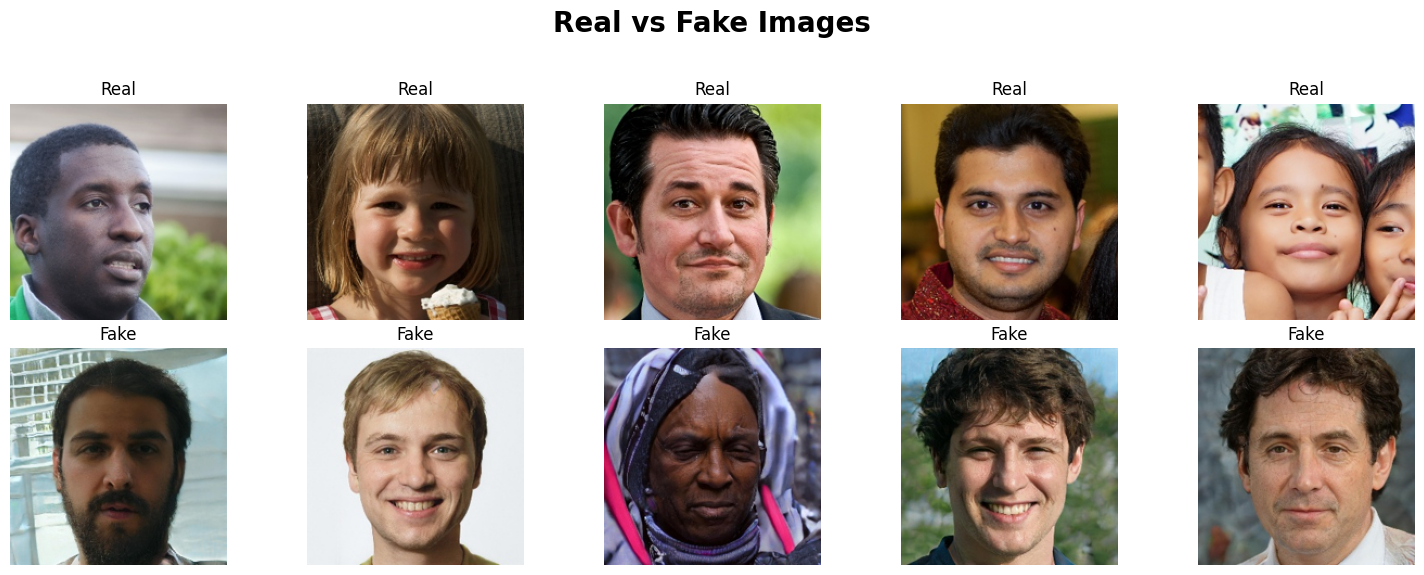

In [5]:
# Function to load and display images from directories
def display_images(real_dir, fake_dir):
    # Indices of the images to display from the real directory
    real_indices = [0, 2, 3, 5, 8]

    # Indices of the images to display from the fake directory
    fake_indices = [0, 3, 11, 14, 21]

    # Load image paths from the real directory
    real_images = [os.path.join(real_dir, img) for i, img in enumerate(os.listdir(real_dir)) if i in real_indices]

    # Load image paths from the fake directory
    fake_images = [os.path.join(fake_dir, img) for i, img in enumerate(os.listdir(fake_dir)) if i in fake_indices]

    # Create a figure with subplots to display images
    n_images = len(real_images)                                      # Number of images to display for real and fake
    fig, axs = plt.subplots(2, n_images, figsize=(15, 6))            # 2 rows (real and fake), n_images columns
    fig.suptitle('Real vs Fake Images', fontsize=20, weight='bold')  # Set the title for the figure

    # Display real images
    for i, img_path in enumerate(real_images):
        img = Image.open(img_path).resize((200, 200))  # Open and resize the image
        axs[0, i].imshow(img)                          # Display the image on the subplot
        axs[0, i].axis('off')                          # Hide the axis
        axs[0, i].set_title('Real')                    # Set the title as 'Real' for real images

    # Display fake images
    for i, img_path in enumerate(fake_images):
        img = Image.open(img_path).resize((200, 200))  # Open and resize the image
        axs[1, i].imshow(img)                          # Display the image on the subplot
        axs[1, i].axis('off')                          # Hide the axis
        axs[1, i].set_title('Fake')                    # Set the title as 'Fake' for fake images

    # Adjust layout for better spacing between plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Paths to the actual directories
real_dir = "/content/real_vs_fake/real-vs-fake/train/real"
fake_dir = "/content/real_vs_fake/real-vs-fake/train/fake"

# Display images from real and fake directories
display_images(real_dir, fake_dir)

# **Define Model Architecture**

In [6]:
# Initialize the Sequential model
model = Sequential()

# Convolutional and Pooling Layers
# These layers extract features from the input images by applying filters and downsampling the feature maps.

# First Convolutional Layer
model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(200,200,3)))
# First Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
# Second Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Third Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
# Third Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Fourth Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation="relu"))
# Fourth Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening Layer
# This layer converts the 2D feature maps into a 1D vector to be fed into the dense layers.
model.add(Flatten())

# Fully Connected (Dense) Layers
# These layers are used for making predictions based on the extracted features.

# First Dense Layer with 512 units
model.add(Dense(units=512, activation="relu"))

# Second Dense Layer with 256 units
model.add(Dense(units=256, activation="relu"))

# Output Layer
# This layer produces the final prediction with a single unit and sigmoid activation for binary classification.
model.add(Dense(units=1, activation="sigmoid"))

# Model Summary
# Display the architecture and parameters of the model.
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,627,713 (51.99 MB)

 Trainable params: 13,627,713 (51.99 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Compilation and Configuration**

In [7]:
# Define optimizer, loss function, and evaluation metric
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# **Model Training**

In [8]:
# Ensure GPU is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define callbacks
# ModelCheckpoint saves the model with the best validation loss during training.
# EarlyStopping stops training early if the validation loss doesn't improve after 10 epochs.
callbacks_list = [
    ModelCheckpoint('best_model.h5.keras', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1),
    EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)
]

# Fit the model
# Train the model on the training dataset for 30 epochs, using validation data to monitor performance.
# The model will perform 40 steps per epoch and 28 validation steps.
# The callbacks will handle saving the best model and stopping early if necessary.
history = model.fit(
    train_dataset,
    steps_per_epoch  = 40,
    epochs           = 75,
    validation_data  = valid_dataset,
    validation_steps = 28,
    callbacks        = callbacks_list
)

Num GPUs Available:  1
Epoch 1/75


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5253 - loss: 1.1044
Epoch 1: val_loss improved from inf to 0.64712, saving model to best_model.h5.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - accuracy: 0.5259 - loss: 1.0973 - val_accuracy: 0.6345 - val_loss: 0.6471
Epoch 2/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6244 - loss: 0.6523
Epoch 2: val_loss did not improve from 0.64712
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.6242 - loss: 0.6525 - val_accuracy: 0.5363 - val_loss: 0.6713
Epoch 3/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6280 - loss: 0.6456
Epoch 3: val_loss did not improve from 0.64712
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step - accuracy: 0.6283 - loss: 0.6453 - val_accuracy: 0.6060 - val_loss: 0.6831
Epoch 4/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6326 - loss: 0.6406
Epoch 4: val_loss improved from 0.64712 to 0.62758, saving model to best_model.h5.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accura

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.7809 - loss: 0.4516 - val_accuracy: 0.7882 - val_loss: 0.4596
Epoch 13/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8224 - loss: 0.4150
Epoch 13: val_loss improved from 0.45964 to 0.41117, saving model to best_model.h5.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.8221 - loss: 0.4152 - val_accuracy: 0.8186 - val_loss: 0.4112
Epoch 14/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7929 - loss: 0.4234
Epoch 14: val_loss did not improve from 0.41117
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 0.7931 - loss: 0.4235 - val_accuracy: 0.8069 - val_loss: 0.4188
Epoch 15/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8277 - loss: 0.3862
Epoch 15: val_loss improved from 0.41117 to 0.38273, saving model to best_model.h5.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.8277 - loss: 0.3863 - val_accuracy: 0.8404 - val_loss: 0.3827
Epoch 16/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s

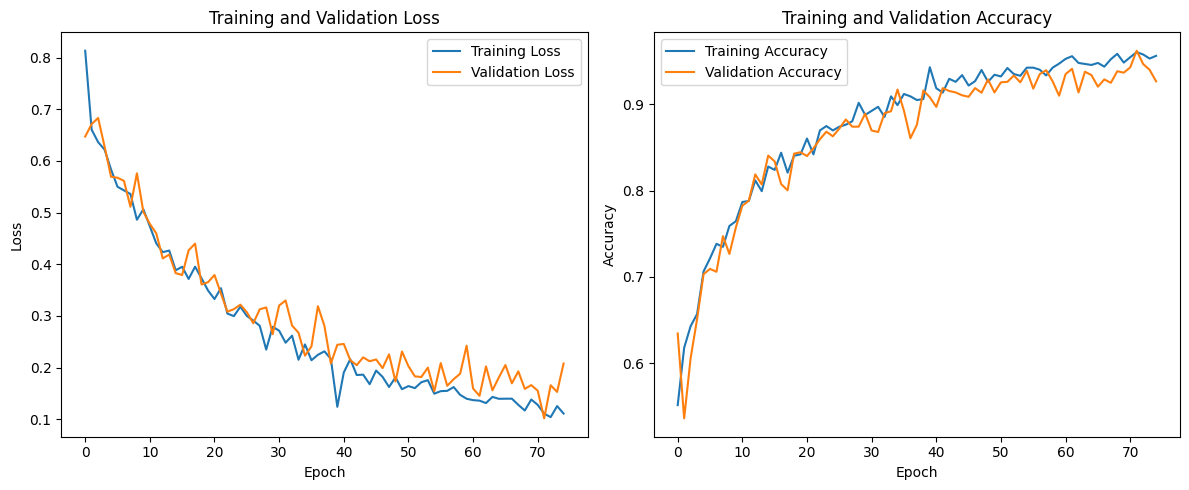

In [9]:
# Extract data from the history object
history_dict = history.history

# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,883,141 (155.96 MB)

 Trainable params: 13,627,713 (51.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,255,428 (103.97 MB)

# **Model Evaluation**

In [11]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 218ms/step - accuracy: 0.9284 - loss: 0.1821
Test Loss: 0.18265078961849213
Test Accuracy: 0.9284999966621399


# **Download The Best Model Weights**

In [12]:
files.download('/content/best_model.h5.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>